In [1]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
os.listdir ('../Skin Cancer 2')

['hmnist_8_8_L.csv',
 'Skin cancer piola.ipynb',
 'dir_imagess',
 'ham10000_images_part_2',
 'model.h5',
 'ham10000_images_part_1',
 '.ipynb_checkpoints',
 'hmnist_8_8_RGB.csv',
 'hmnist_28_28_L.csv',
 'dir_images',
 'hmnist_28_28_RGB.csv',
 'HAM10000_metadata.csv']

In [5]:
# Crear un directorio

dir_images = 'dir_images'
os.mkdir (dir_images)

# Crear dentro del directorio las carpetas train y val

train_images = os.path.join (dir_images, 'train_images')
os.mkdir (train_images)

val_images = os.path.join (dir_images, 'val_images')
os.mkdir (val_images)

# Crear dentro de train y val 7 carpetas (cada diagnostico)

nv = os.path.join(train_images, 'nv')
os.mkdir(nv)
mel = os.path.join(train_images, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_images, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_images, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_images, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_images, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_images, 'df')
os.mkdir(df)

nv = os.path.join(val_images, 'nv')
os.mkdir(nv)
mel = os.path.join(val_images, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_images, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_images, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_images, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_images, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_images, 'df')
os.mkdir(df)


In [4]:
df_skin = pd.read_csv ('HAM10000_metadata.csv')

In [5]:
df_skin.head ()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
# cuantas imágenes estan asociadas a lesion id

df_skin.groupby ('lesion_id').count ()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1
...,...,...,...,...,...,...
HAM_0007624,1,1,1,1,1,1
HAM_0007625,2,2,2,2,2,2
HAM_0007626,1,1,1,1,1,1


In [7]:
df = df_skin.groupby ('lesion_id').count ()

In [8]:
df = df [df ['image_id'] == 1]

In [9]:
df.head ()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000001,1,1,1,1,1,1
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1
HAM_0000007,1,1,1,1,1,1
HAM_0000008,1,1,1,1,1,1


In [10]:
# Lesion id con una sola imagen

df.reset_index(inplace = True)

df.head ()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [11]:
# Id de lesiones que tengan mas de una imagen o una sola

def identify_duplicates_images (x):
    unique_list = list (df ['lesion_id'])
    if x in unique_list:
        return 'sin duplicaciones'
    else:
        return 'duplicado'

In [12]:
# Crear una nueva columna para decir si esta duplicado o no. Es una copia de lesion_id

df_skin ['duplicates'] = df_skin ['lesion_id']

In [13]:
# Aplicar la función identify_duplicates_images a la nueva columna duplicates

df_skin ['duplicates'] = df_skin ['duplicates'].apply (identify_duplicates_images)

In [14]:
df_skin.sample (5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
1020,HAM_0005291,ISIC_0026907,bkl,consensus,55.0,male,back,sin duplicaciones
6521,HAM_0007584,ISIC_0025139,nv,follow_up,35.0,female,trunk,sin duplicaciones
964,HAM_0007427,ISIC_0033945,bkl,consensus,60.0,female,back,duplicado
9706,HAM_0006746,ISIC_0026872,akiec,histo,85.0,male,lower extremity,sin duplicaciones
778,HAM_0007337,ISIC_0026912,bkl,confocal,85.0,female,face,sin duplicaciones


In [15]:
df_skin ['duplicates'].value_counts ()

sin duplicaciones    5514
duplicado            4501
Name: duplicates, dtype: int64

In [16]:
df = df_skin [df_skin ['duplicates'] == 'sin duplicaciones']

In [17]:
df ['duplicates'].value_counts ()

sin duplicaciones    5514
Name: duplicates, dtype: int64

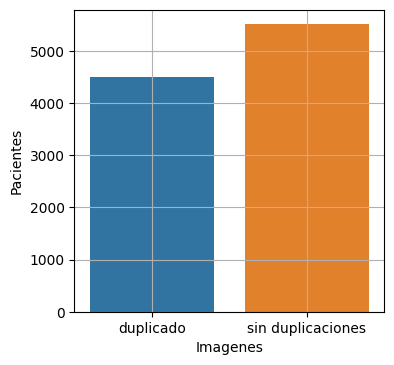

In [20]:
plt.figure(figsize=(4,4), dpi = 100)
sns.countplot (df_skin['duplicates'])

plt.ylabel ('Pacientes')
plt.xlabel ('Imagenes')
plt.xticks()
plt.grid ()

plt.show ()

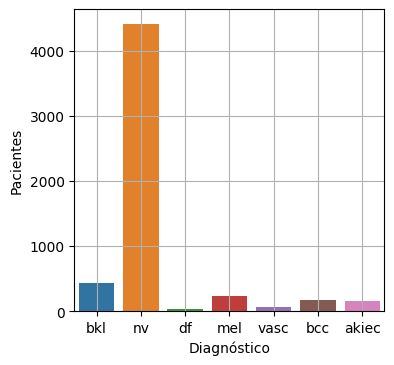

In [21]:
plt.figure(figsize=(4,4), dpi = 100)
sns.countplot (df['dx'])
plt.xlabel ('Diagnóstico')
plt.ylabel ('Pacientes')
plt.xticks()
plt.grid ()
plt.show ()

In [22]:
df.head ()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,sin duplicaciones
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,sin duplicaciones
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,sin duplicaciones
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,sin duplicaciones
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,sin duplicaciones


In [23]:
# Uso df para crear val ya que no tiene duplicaciones

y = df ['dx']

y, df_val = train_test_split (df, test_size = 0.17, random_state = 101, stratify = y)

In [24]:
df_val.shape

(938, 8)

In [25]:
y.shape

(4576, 8)

In [26]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [27]:
df_val.head ()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
9446,HAM_0007333,ISIC_0033614,nv,consensus,40.0,male,unknown,sin duplicaciones
5199,HAM_0005819,ISIC_0025111,nv,follow_up,45.0,male,trunk,sin duplicaciones
6140,HAM_0004336,ISIC_0031760,nv,follow_up,45.0,male,abdomen,sin duplicaciones
3595,HAM_0006385,ISIC_0026733,nv,follow_up,50.0,female,trunk,sin duplicaciones
3419,HAM_0002080,ISIC_0029619,nv,follow_up,45.0,female,lower extremity,sin duplicaciones


In [28]:
# Crear un set de train sin las imagenes usadas para el set val

# Uso df_skin exlucyendo las filas que use para val (de 'df')


# Función identifica si una imagen es del set train o val

def identify_val_rows (x):
    # Crear una lista de los lesion_id en val
    val_list = list (df_val ['image_id'])
    if str (x) in val_list:
        return 'val'
    else:
        return 'train'

In [29]:
# Crear una nueva columna para decir si es val o train. Es una copia de image_id

df_skin ['train o val'] = df_skin ['image_id']

In [30]:
# Aplicar la función identify_val_rows a columna 'train o val'

df_skin ['train o val'] = df_skin ['train o val'].apply(identify_val_rows)

In [36]:
df_skin.sample (5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,train o val
8312,HAM_0003742,ISIC_0031631,nv,histo,20.0,female,back,duplicado,train
2115,HAM_0005747,ISIC_0027502,mel,histo,45.0,male,lower extremity,duplicado,train
1206,HAM_0001841,ISIC_0025771,df,consensus,35.0,female,lower extremity,sin duplicaciones,train
1035,HAM_0002034,ISIC_0027954,bkl,consensus,5.0,male,abdomen,sin duplicaciones,val
1172,HAM_0007396,ISIC_0033810,df,consensus,35.0,female,lower extremity,duplicado,train


In [37]:
df.loc[df['lesion_id'] == 'HAM_0002034']

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
1035,HAM_0002034,ISIC_0027954,bkl,consensus,5.0,male,abdomen,sin duplicaciones


In [38]:
df_skin ['train o val'].value_counts ()

train    9077
val       938
Name: train o val, dtype: int64

In [39]:
df_train = df_skin [df_skin ['train o val'] == 'train']

In [40]:
df_train ['train o val'].value_counts ()

train    9077
Name: train o val, dtype: int64

In [41]:
df_train ['dx'].value_counts ()

# Excluye las filas/imágenes utilizadas en val

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [49]:
# Transferir las imagenes a sus correspondientes carpetas

# Indexar por image_id en df_skin

df_skin.set_index ('image_id', inplace = True)

In [50]:
# Lista de las imagenes en sus carpetas originales

carpeta1 = os.listdir ('../Skin Cancer 2/ham10000_images_part_1')
carpeta2 = os.listdir ('../Skin Cancer 2/ham10000_images_part_2')

In [53]:
# Lista de las imagenes en train y val

train_list = list (df_train ['image_id'])
val_list = list (df_val ['image_id'])

In [40]:
# Transferir las imágenes a train

for image in train_list:
    fname = image + '.jpg'
    label = df_skin.loc [image, 'dx']
    
    if fname in carpeta1:
        # Path origen de la imágen
        source = os.path.join ('../Skin Cancer 2/ham10000_images_part_1', fname)
        # Destino de la misma
        destination = os.path.join (train_images, label, fname)
        # Copiar la imágen del source al destino
        shutil.copyfile (source, destination)
    
    if fname in carpeta2:
        # Path origen de la imágen
        source = os.path.join('../Skin Cancer 2/ham10000_images_part_2', fname)
        # Destino de la misma
        destination = os.path.join(train_images, label, fname)
        # Copiar la imágen del source al destino
        shutil.copyfile (source, destination)
        
        


In [41]:
# Transferir las imágenes a val

for image in val_list:
    
    fname = image + '.jpg'
    label = df_skin.loc[image,'dx']
    
    if fname in carpeta1:
        # Path origen de la imágen
        source = os.path.join('../Skin Cancer 2/ham10000_images_part_1', fname)
        # Destino de la misma
        destination = os.path.join(val_images, label, fname)
        # Copiar la imágen del source al destino
        shutil.copyfile(source, destination)

    if fname in carpeta2:
        # Path origen de la imágen
        source = os.path.join('../Skin Cancer 2/ham10000_images_part_2', fname)
        # Destino de la misma
        destination = os.path.join (val_images, label, fname)
        # Copiar la imágen del source al destino
        shutil.copyfile (source, destination)

In [41]:
print(len(os.listdir('dir_images/train_images/nv')))
print(len(os.listdir('dir_images/train_images/mel')))
print(len(os.listdir('dir_images/train_images/bkl')))
print(len(os.listdir('dir_images/train_images/bcc')))
print(len(os.listdir('dir_images/train_images/akiec')))
print(len(os.listdir('dir_images/train_images/vasc')))
print(len(os.listdir('dir_images/train_images/df')))

5954
5920
5920
5858
5217
5290
4410


In [42]:
print(len(os.listdir('dir_images/val_images/nv')))
print(len(os.listdir('dir_images/val_images/mel')))
print(len(os.listdir('dir_images/val_images/bkl')))
print(len(os.listdir('dir_images/val_images/bcc')))
print(len(os.listdir('dir_images/val_images/akiec')))
print(len(os.listdir('dir_images/val_images/vasc')))
print(len(os.listdir('dir_images/val_images/df')))

751
39
75
30
26
11
6


In [44]:
# Crear un directorio para las categorias que hago augmentation
# nv no porque ya tengo un n grande

categorias = ['mel','bkl','bcc','akiec','vasc','df']

In [45]:
for categoria in categorias:
    
    
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = categoria

    img_list = os.listdir('dir_images/train_images/' + img_class)

    for fname in img_list:
            src = os.path.join('dir_images/train_images/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)

    path = aug_dir
    save_path = 'dir_images/train_images/' + img_class

    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)


    num_aug_images_wanted = 6000 
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):
        imgs, labels = next(aug_datagen)
        
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [43]:
print(len(os.listdir('dir_images/train_images/nv')))
print(len(os.listdir('dir_images/train_images/mel')))
print(len(os.listdir('dir_images/train_images/bkl')))
print(len(os.listdir('dir_images/train_images/bcc')))
print(len(os.listdir('dir_images/train_images/akiec')))
print(len(os.listdir('dir_images/train_images/vasc')))
print(len(os.listdir('dir_images/train_images/df')))

5954
5920
5920
5858
5217
5290
4410


In [44]:
print(len(os.listdir('dir_images/val_images/nv')))
print(len(os.listdir('dir_images/val_images/mel')))
print(len(os.listdir('dir_images/val_images/bkl')))
print(len(os.listdir('dir_images/val_images/bcc')))
print(len(os.listdir('dir_images/val_images/akiec')))
print(len(os.listdir('dir_images/val_images/vasc')))
print(len(os.listdir('dir_images/val_images/df')))

751
39
75
30
26
11
6


In [42]:
df_skin.shape

(10015, 9)

In [43]:
df.shape

(5514, 8)

In [44]:
df_train.shape

(9077, 9)

In [45]:
df_val.shape

(938, 8)

In [46]:
df_skin.head (1)

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,train o val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicado,train


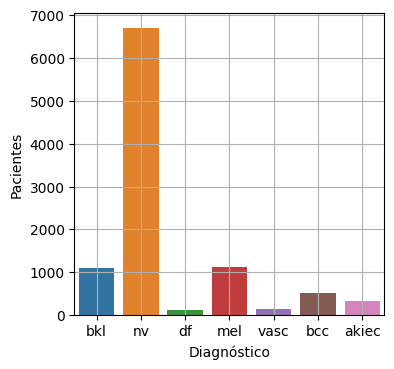

In [47]:
plt.figure(figsize=(4,4), dpi = 100)
sns.countplot (df_skin['dx'])
plt.xlabel ('Diagnóstico')
plt.ylabel ('Pacientes')
plt.xticks()
plt.grid ()
plt.show ()

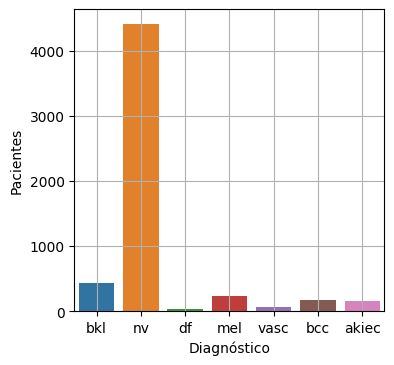

In [48]:
plt.figure(figsize=(4,4), dpi = 100)
sns.countplot (df['dx'])
plt.xlabel ('Diagnóstico')
plt.ylabel ('Pacientes')
plt.xticks()
plt.grid ()
plt.show ()

In [54]:
dic = {'bkl': 5920, 'nv': 5954,'df': 4410,'mel': 5920,'vasc': 5290,'bcc': 5858,'akiec':5217}

In [56]:
labels = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']
values = [5920, 5954, 4410, 5920, 5290, 5858, 5217]

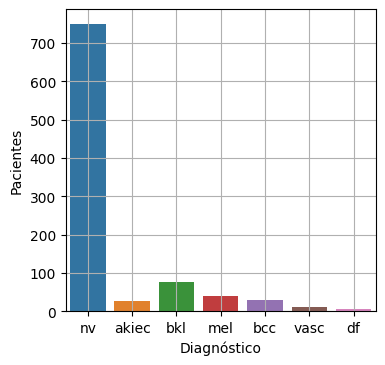

In [49]:
plt.figure(figsize=(4,4), dpi = 100)
sns.countplot (df_val['dx'])
plt.xlabel ('Diagnóstico')
plt.ylabel ('Pacientes')
plt.xticks()
plt.grid ()
plt.show ()

In [69]:
train_path = 'dir_images/train_images'
val_path = 'dir_images/val_images'

In [70]:
train_samples = len (df_train)
val_samples = len (df_val)

In [71]:
train_batch_size = 10
val_batch_size = 10
image_size = 224

In [72]:
train_steps = np.ceil (train_samples / train_batch_size)
val_steps = np.ceil (val_samples / val_batch_size)

In [73]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

In [74]:
train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

Found 38569 images belonging to 7 classes.


In [75]:
valid_batches = datagen.flow_from_directory(val_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

Found 938 images belonging to 7 classes.


In [76]:
test_batches = datagen.flow_from_directory(val_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 938 images belonging to 7 classes.


In [77]:
# Mobile net

mobile_net = tensorflow.keras.applications.mobilenet.MobileNet()

In [78]:
mobile_net.summary ()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [79]:
len (mobile_net.layers)

93

In [80]:
# Arquitectura del modelo

# Excluir las ultimas 5 capas del modelo
# Incluye hasta global_average_pooling2d

x = mobile_net.layers [-6].output

# Crear una nueva capa densa para predicciones. 7 categorías

x = Dropout (0.25)(x) # Dropout reduce el overfitting al train

predictions = Dense (7, activation = 'softmax')(x)

model = Model (inputs = mobile_net.input, outputs = predictions)

In [81]:
model.summary ()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [82]:
len (model.layers)

90

In [83]:
# Elección de capas a ser entrenadas, las ultimas 23

# Las demas no se entrenan

for layer in mobile_net.layers [:-23]:
    layer.trainable = False

# Entrenar el modelo



In [84]:
def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)
    
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [85]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [86]:
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [87]:
# Se le agrega peso a melanoma para ser más sensible a la categoría

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel 
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [88]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
908/908 [==============================] - ETA: 0s - loss: 1.7195 - categorical_accuracy: 0.5115 - top_2_accuracy: 0.7155 - top_3_accuracy: 0.8415
Epoch 00001: val_top_3_accuracy improved from -inf to 0.95842, saving model to model.h5
908/908 [==============================] - 491s 540ms/step - loss: 1.7195 - categorical_accuracy: 0.5115 - top_2_accuracy: 0.7155 - top_3_accuracy: 0.8415 - val_loss: 0.5974 - val_categorical_accuracy: 0.8081 - val_top_2_accuracy: 0.8987 - val_top_3_accuracy: 0.9584 - lr: 0.0100
Epoch 2/30
908/908 [==============================] - ETA: 0s - loss: 1.2110 - categorical_accuracy: 0.6330 - top_2_accuracy: 0.8269 - top_3_accuracy: 0.9228
Epoch 00002: val_top_3_accuracy did not improve from 0.95842
908/908 [==============================] - 489s 539ms/step - loss: 1.2110 - categorical_accuracy: 0.6330 - top_2_accuracy: 0.8269 - top_3_accuracy: 0.9228 - val_loss: 0.6893 - val

Epoch 16/30
908/908 [==============================] - ETA: 0s - loss: 0.3005 - categorical_accuracy: 0.9067 - top_2_accuracy: 0.9850 - top_3_accuracy: 0.9974
Epoch 00016: val_top_3_accuracy did not improve from 0.98507
908/908 [==============================] - 488s 538ms/step - loss: 0.3005 - categorical_accuracy: 0.9067 - top_2_accuracy: 0.9850 - top_3_accuracy: 0.9974 - val_loss: 0.3773 - val_categorical_accuracy: 0.8806 - val_top_2_accuracy: 0.9606 - val_top_3_accuracy: 0.9797 - lr: 0.0012
Epoch 17/30
908/908 [==============================] - ETA: 0s - loss: 0.2752 - categorical_accuracy: 0.9191 - top_2_accuracy: 0.9841 - top_3_accuracy: 0.9972
Epoch 00017: val_top_3_accuracy did not improve from 0.98507

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
908/908 [==============================] - 485s 535ms/step - loss: 0.2752 - categorical_accuracy: 0.9191 - top_2_accuracy: 0.9841 - top_3_accuracy: 0.9972 - val_loss: 0.3618 - val_categorical_accurac

In [89]:
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [90]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate (test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

938/938 [==============================] - 46s 49ms/step - loss: 0.3687 - categorical_accuracy: 0.9030 - top_2_accuracy: 0.9616 - top_3_accuracy: 0.9840
val_loss: 0.3686959743499756
val_cat_acc: 0.9029850959777832
val_top_2_acc: 0.9616204500198364
val_top_3_acc: 0.9840085506439209


In [93]:
model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate (test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

938/938 [==============================] - 45s 48ms/step - loss: 0.3713 - categorical_accuracy: 0.8934 - top_2_accuracy: 0.9606 - top_3_accuracy: 0.9861
val_loss: 0.3713197708129883
val_cat_acc: 0.8933901786804199
val_top_2_acc: 0.9605543613433838
val_top_3_acc: 0.9861407279968262


In [94]:
# Plot de las curvas de train loss y validation

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

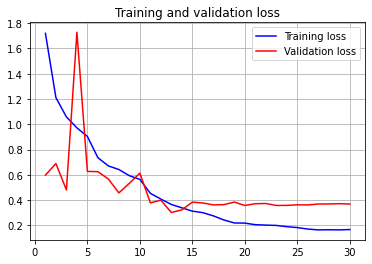

<Figure size 432x288 with 0 Axes>

In [95]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.figure()

plt.show ()

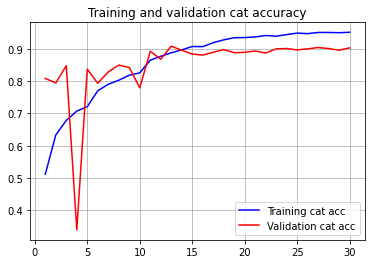

<Figure size 432x288 with 0 Axes>

In [96]:
plt.plot(epochs, acc, 'b', label='Training cat acc')
plt.plot(epochs, val_acc, 'r', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.grid ()
plt.figure()

plt.show ()

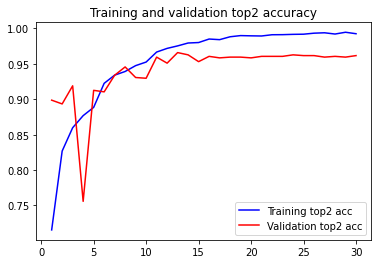

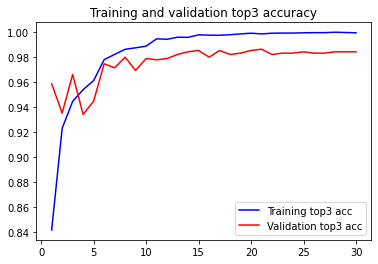

In [98]:
plt.plot(epochs, train_top2_acc, 'b', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'r', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'b', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'r', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [99]:
test_labels = test_batches.classes

In [100]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [101]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [104]:
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)

938/938 [==============================] - 45s 48ms/step


In [105]:
predictions.shape

(938, 7)

In [106]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [107]:
test_labels.shape

(938,)

In [108]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [109]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 14   3   4   0   3   2   0]
 [  1  26   2   0   1   0   0]
 [  0   2  47   0  11  15   0]
 [  0   0   0   4   0   2   0]
 [  2   2   3   0  22  10   0]
 [  3   4   7   1  21 715   0]
 [  0   0   0   0   0   1  10]]


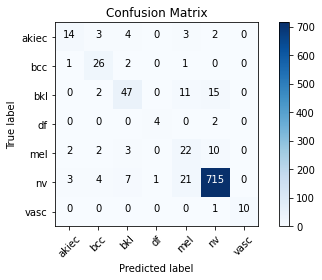

In [118]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']


plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')



In [111]:
# Indice de la clase con score de prob mas alto
y_pred = np.argmax(predictions, axis=1)

y_true = test_batches.classes

In [112]:
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.70      0.54      0.61        26
         bcc       0.70      0.87      0.78        30
         bkl       0.75      0.63      0.68        75
          df       0.80      0.67      0.73         6
         mel       0.38      0.56      0.45        39
          nv       0.96      0.95      0.96       751
        vasc       1.00      0.91      0.95        11

    accuracy                           0.89       938
   macro avg       0.76      0.73      0.74       938
weighted avg       0.90      0.89      0.90       938



In [126]:
filepath = "model.h5"


In [118]:
filepath = "model.h5"


history = model.fit (train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=15, verbose=1,
                   )

Epoch 1/15
908/908 [==============================] - 484s 534ms/step - loss: 1.7110 - categorical_accuracy: 0.5095 - val_loss: 1.0925 - val_categorical_accuracy: 0.7388
Epoch 2/15
908/908 [==============================] - 483s 532ms/step - loss: 1.2391 - categorical_accuracy: 0.6228 - val_loss: 0.6007 - val_categorical_accuracy: 0.7814
Epoch 3/15
908/908 [==============================] - 479s 528ms/step - loss: 1.0665 - categorical_accuracy: 0.6728 - val_loss: 0.4831 - val_categorical_accuracy: 0.8337
Epoch 4/15
908/908 [==============================] - 479s 528ms/step - loss: 1.0143 - categorical_accuracy: 0.6865 - val_loss: 0.5709 - val_categorical_accuracy: 0.8486
Epoch 5/15
908/908 [==============================] - 477s 525ms/step - loss: 0.9456 - categorical_accuracy: 0.7121 - val_loss: 1.2805 - val_categorical_accuracy: 0.5330
Epoch 6/15
908/908 [==============================] - 477s 525ms/step - loss: 0.8578 - categorical_accuracy: 0.7406 - val_loss: 0.7346 - val_categoric

In [119]:
model.metrics_names

['loss', 'categorical_accuracy']

In [123]:
val_loss, val_cat_acc = \
model.evaluate (test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)


938/938 [==============================] - 46s 49ms/step - loss: 0.8035 - categorical_accuracy: 0.8326
val_loss: 0.803459644317627
val_cat_acc: 0.8326225876808167


In [120]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

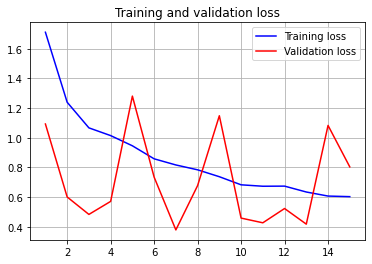

<Figure size 432x288 with 0 Axes>

In [121]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.figure()

plt.show ()

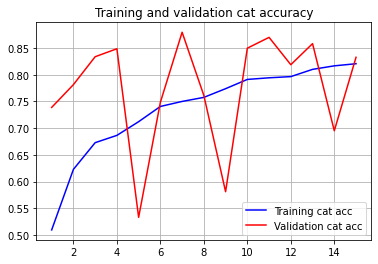

<Figure size 432x288 with 0 Axes>

In [122]:
plt.plot(epochs, acc, 'b', label='Training cat acc')
plt.plot(epochs, val_acc, 'r', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.grid ()
plt.figure()

plt.show ()

# Confusion Matrix

In [128]:
test_labels = test_batches.classes

In [129]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [130]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [132]:
predictions = model.predict (test_batches, steps = len (df_val), verbose = 1)

938/938 [==============================] - 44s 47ms/step


In [133]:
predictions.shape

(938, 7)

In [135]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [136]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [138]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  0   0   2   6   9   9   0]
 [  0  13   0   6   3   8   0]
 [  0   2   4   6  18  45   0]
 [  0   0   0   3   0   3   0]
 [  0   0   0   1  16  22   0]
 [  0   2   0   5   8 735   1]
 [  0   0   0   0   0   1  10]]


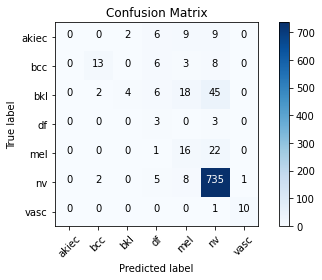

In [137]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [139]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [141]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        26
         bcc       0.76      0.43      0.55        30
         bkl       0.67      0.05      0.10        75
          df       0.11      0.50      0.18         6
         mel       0.30      0.41      0.34        39
          nv       0.89      0.98      0.93       751
        vasc       0.91      0.91      0.91        11

    accuracy                           0.83       938
   macro avg       0.52      0.47      0.43       938
weighted avg       0.82      0.83      0.80       938



/home/dani/ambiente1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
